Simple Example
=====

Approximating a simple intractable distribution: Gaussian with a Gaussian prior on it's log variance. Approximation is with a Gaussian.

I'll be putting in explanations of what's going in each cell after the cell:

In [1]:
# %load ../examples/black_box_svi.py
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt
import holoviews as hv
hv.notebook_extension(bokeh=True)

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm

from autograd import grad

/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Just imports. Whe have to import numpy _through_ `autograd`, hence the `autograd.numpy as np`, to have access to automatic differentiation for all of our numpy code.

In [3]:
# %load ../examples/optimizers.py
from __future__ import absolute_import

import autograd.numpy as np
from builtins import range

def adam(grad, x, callback=None, num_iters=100,
         step_size=0.001, b1=0.9, b2=0.999, eps=10**-8):
    """Adam as described in http://arxiv.org/pdf/1412.6980.pdf.
    It's basically RMSprop with momentum and some correction terms."""
    m = np.zeros(len(x))
    v = np.zeros(len(x))
    for i in range(num_iters):
        g = grad(x, i)
        if callback: callback(x, i, g)
        m = (1 - b1) * g      + b1 * m  # First  moment estimate.
        v = (1 - b2) * (g**2) + b2 * v  # Second moment estimate.
        mhat = m / (1 - b1**(i + 1))    # Bias correction.
        vhat = v / (1 - b2**(i + 1))
        x -= step_size*mhat/(np.sqrt(vhat) + eps)
    return x

This isn't really necessary, we could just use vanilla SGD, but this is probably slightly better. Defines the adaptive gradient updates of the parameters, and the optimisation loop. Optionally, we can add a callback function.

In [4]:
def black_box_variational_inference(logprob, D, num_samples):
    """Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557"""

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

Sample from our variational distribution, and then use this to define a lower bound (a _variational_ lower bound) on the marginal likelihood. Then, take a gradient of this stochastic estimate of the lower bound so we can perform gradient updates to the parameters we used to sample from the variational distribution; this is black box variational inference in 23 lines minus comments.

In [5]:
# Specify an inference problem by its unnormalized log-posterior.
D = 2
def log_posterior(x, t):
    """An example 2D intractable distribution:
    a Gaussian evaluated at zero with a Gaussian prior on the log-variance."""
    mu, log_sigma = x[:, 0], x[:, 1]
    prior       = norm.logpdf(log_sigma, 0, 1.35)
    likelihood  = norm.logpdf(mu,        0, np.exp(log_sigma))
    return prior + likelihood

Here's our intractable distribution, it even says it right there, and we have a graph of it coming up!

In [6]:
# Build variational objective.
objective, gradient, unpack_params = \
    black_box_variational_inference(log_posterior, D, num_samples=2000)

Running the function we defined above...

In [7]:
def isocontours(func, xlimits=[-2, 2], ylimits=[-4, 2], numticks=512):
    x = np.linspace(*xlimits, num=numticks)
    y = np.linspace(*ylimits, num=numticks)
    X, Y = np.meshgrid(x, y)
    zs = func(np.concatenate([np.atleast_2d(X.ravel()), np.atleast_2d(Y.ravel())]).T)
    Z = zs.reshape(X.shape)
    return Z

This is going to give us an image with the contours of a distribution. Going to use it to graph the intractable distribution from above.

In [8]:
def callback(params, t, g):
    print("Iteration {} lower bound {}".format(t, -objective(params, t)))

    plt.cla()
    target_distribution = lambda x : np.exp(log_posterior(x, t))
    plot_isocontours(ax, target_distribution)

    mean, log_std = unpack_params(params)
    variational_contour = lambda x: mvn.pdf(x, mean, np.diag(np.exp(2*log_std)))
    plot_isocontours(ax, variational_contour)
    plt.draw()
    plt.pause(1.0/30.0)

Our callback function while we're running the updates. It's just going to print out the progress as we loop around in the `adam` function above.

In [9]:
target = lambda x: np.exp(log_posterior(x, 1))

Defining our target distribution.

:Overlay
   .Image.I :Image   [x,y]   (z)
   .Level.I :NdOverlay   [Levels]
      :Contours   [x,y]   (z)
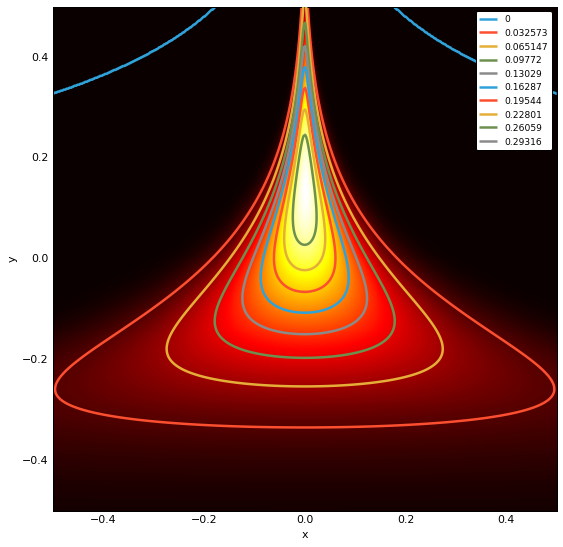

In [12]:
%%output size=250
Z = isocontours(target)
target_distribution = hv.Image(Z)
hv.operation.contours(target_distribution, levels=np.linspace(0,max(Z.ravel()),10))

It's that graph of the intractable distribution I told you about!

In [13]:
init_mean    = -1 * np.ones(D)
init_log_std = -5 * np.ones(D)

Initialising the parameters of the variational approximation.

:Overlay
   .Image.I :Image   [x,y]   (z)
   .Level.I :NdOverlay   [Levels]
      :Contours   [x,y]   (z)
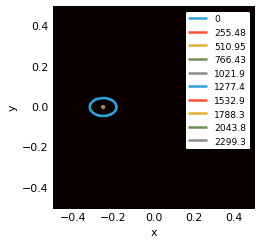

In [14]:
variational_contour = lambda x: mvn.pdf(x, init_mean, np.diag(np.exp(2*init_log_std)))
Z = isocontours(variational_contour)
variational_distribution = hv.Image(Z)
hv.operation.contours(variational_distribution, levels=np.linspace(0,max(Z.ravel()),10))

Graph of the current variational approximation, centered at zero as we might expect.

In [15]:
print("Optimizing variational parameters...")
init_var_params = np.concatenate([init_mean, init_log_std])
variational_params = adam(gradient, init_var_params, step_size=0.1, num_iters=2000, callback=None)

Optimizing variational parameters...


Then we can optimise the parameters with no callback, so we see no progress, and it should finish fairly quickly.

:Layout
   .Overlay.I :Overlay
      .Image.I :Image   [x,y]   (z)
      .Level.I :NdOverlay   [Levels]
         :Contours   [x,y]   (z)
   .Image.I   :Image   [x,y]   (z)
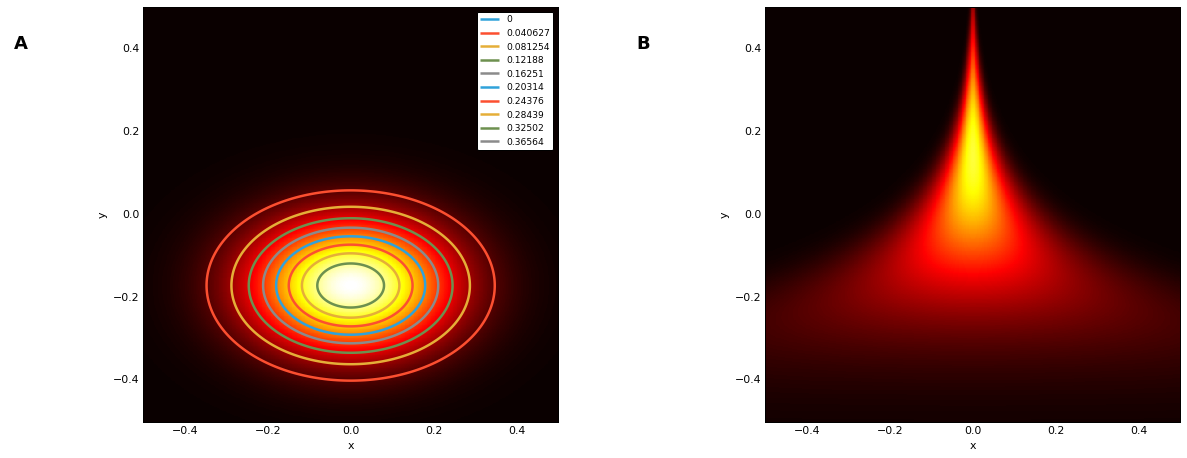

In [19]:
%%output size=200
mean, log_std = unpack_params(variational_params)
variational_contour = lambda x: mvn.pdf(x, mean, np.diag(np.exp(2*log_std)))
Z = isocontours(variational_contour)
variational_distribution = hv.Image(Z)
hv.operation.contours(variational_distribution, levels=np.linspace(0,max(Z.ravel()),10))+target_distribution

Now we can graph the isotropic approximation next to the intractable distribution and see that we've not really got a perfect approximation, but at least it's doing its best, right?

Bayesian Neural Network
========

Next, fitting a Bayesian neural network in only a few more lines:

In [20]:
def make_nn_funs(layer_sizes, L2_reg, noise_variance, nonlinearity=np.tanh):
    """These functions implement a standard multi-layer perceptron,
    vectorized over both training examples and weight samples."""
    shapes = list(zip(layer_sizes[:-1], layer_sizes[1:]))
    num_weights = sum((m+1)*n for m, n in shapes)

    def unpack_layers(weights):
        num_weight_sets = len(weights)
        for m, n in shapes:
            yield weights[:, :m*n]     .reshape((num_weight_sets, m, n)),\
                  weights[:, m*n:m*n+n].reshape((num_weight_sets, 1, n))
            weights = weights[:, (m+1)*n:]

    def predictions(weights, inputs):
        """weights is shape (num_weight_samples x num_weights)
           inputs  is shape (num_datapoints x D)"""
        inputs = np.expand_dims(inputs, 0)
        for W, b in unpack_layers(weights):
            outputs = np.einsum('mnd,mdo->mno', inputs, W) + b
            inputs = nonlinearity(outputs)
        return outputs

    def logprob(weights, inputs, targets):
        log_prior = -L2_reg * np.sum(weights**2, axis=1)
        preds = predictions(weights, inputs)
        log_lik = -np.sum((preds - targets)**2, axis=1)[:, 0] / noise_variance
        return log_prior + log_lik

    return num_weights, predictions, logprob

These nested functions are kind of complicated. One of the strange parts above is the `unpack_layers` function. This is a quirk of how `autograd` works, and the fact that they wanted to write this in as few lines as possible. The `grad` function of `autograd` only takes the gradient of a single numpy array argument to a function (you state which argument, or it defaults to the first), so in order to only call `grad` once they have to unpack the weights from a single large array. Alternatively, they could have had all of these parameters in lists and iterated over the `grad` calls (this is kind of what Lasagne does, keeping everything in lists which are assumed to stay in the correct order). But, they already wrote the `black_box_variational_inference` function above, and they're not going to rewrite it.

In `predictions`, we're getting the output of the network for a given input and set of weights. They do this in as few lines as possible using the completely opaque `np.einsum`, which is a matrix operation in [Einstein notation][einstein]. This seems like a really useful thing to understand well, but, like regular expressions, not something you're going to remember without regular use.

Finally, we describe the log probability, which is just an L2 regularised squared error loss function.

[einstein]: https://en.wikipedia.org/wiki/Einstein_notation

In [21]:
def build_toy_dataset(n_data=40, noise_std=0.1):
    D = 1
    rs = npr.RandomState(0)
    inputs  = np.concatenate([np.linspace(0, 2, num=n_data/2),
                              np.linspace(6, 8, num=n_data/2)])
    targets = np.cos(inputs) + rs.randn(n_data) * noise_std
    inputs = (inputs - 4.0) / 4.0
    inputs  = inputs.reshape((len(inputs), D))
    targets = targets.reshape((len(targets), D))
    return inputs, targets

Defining a simple 1D regression problem, so we can visualise the output.

In [22]:
# Specify inference problem by its unnormalized log-posterior.
rbf = lambda x: norm.pdf(x, 0, 1)
sq = lambda x: np.sin(x)
num_weights, predictions, logprob = \
    make_nn_funs(layer_sizes=[1, 10, 10, 1], L2_reg=0.01,
                 noise_variance = 0.01, nonlinearity=rbf)

Instance the network, with an unconventional rbf nonlinearity.

In [23]:
inputs, targets = build_toy_dataset()
log_posterior = lambda weights, t: logprob(weights, inputs, targets)

Define our log posterior, and instance the dataset.

:Curve   [x]   (y)
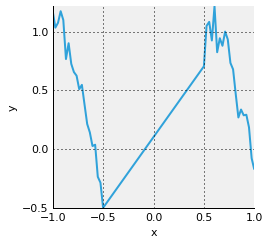

In [24]:
hv.Curve(zip(inputs,targets))

Looking at our toy dataset.

In [25]:
# Build variational objective.
objective, gradient, unpack_params = \
    black_box_variational_inference(log_posterior, num_weights,
                                    num_samples=20)

def callback(params, t, g):
    print("Iteration {} lower bound {}".format(t, -objective(params, t)))
    
# Initialize variational parameters
rs = npr.RandomState(0)
init_mean    = rs.randn(num_weights)
init_log_std = -1 * np.ones(num_weights)
init_var_params = np.concatenate([init_mean, init_log_std])

Now we call the _same_ `black_box_variational_inference` function from above, so we're using an isotropic Gaussian variational distribution on all the weights in our network. Then, we initialise all the variational parameters we're going to need.

In [26]:
def sample_predictions(params, inputs):
    # Sample functions from posterior.
    #rs = npr.RandomState(0)
    mean, log_std = unpack_params(params)
    sample_weights = rs.randn(10, num_weights) * np.exp(log_std) + mean
    return predictions(sample_weights, inputs)

:Overlay
   .Curve.I    :Curve   [x]   (y)
   .Curve.II   :Curve   [x]   (y)
   .Curve.III  :Curve   [x]   (y)
   .Curve.IV   :Curve   [x]   (y)
   .Curve.V    :Curve   [x]   (y)
   .Curve.VI   :Curve   [x]   (y)
   .Curve.VII  :Curve   [x]   (y)
   .Curve.VIII :Curve   [x]   (y)
   .Curve.IX   :Curve   [x]   (y)
   .Curve.X    :Curve   [x]   (y)
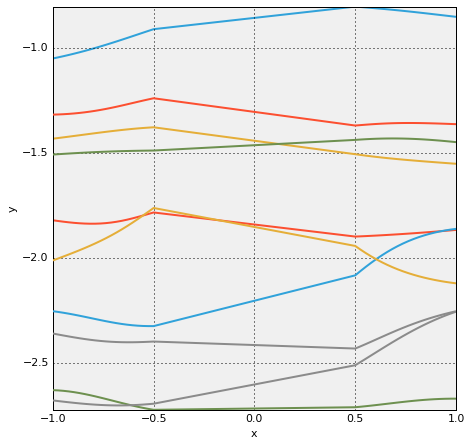

In [28]:
%%output size=200
preds = sample_predictions(init_var_params, inputs)
hv.Overlay([hv.Curve(zip(inputs.ravel(), p.ravel())) for p in preds])

Looking at some of the outputs from the network _before_ training. Obviously, the match to the dataset above isn't great.

In [29]:
print("Optimizing variational parameters...")
variational_params = adam(gradient, init_var_params,
                          step_size=0.1, num_iters=1000, callback=callback)

Optimizing variational parameters...
Iteration 0 lower bound -23837.8412344
Iteration 1 lower bound -12701.1404043
Iteration 2 lower bound -6494.77525443
Iteration 3 lower bound -3199.99333708
Iteration 4 lower bound -2128.84844724
Iteration 5 lower bound -1348.38349564
Iteration 6 lower bound -1597.58282418
Iteration 7 lower bound -1132.5283615
Iteration 8 lower bound -1552.14377848
Iteration 9 lower bound -1335.781635
Iteration 10 lower bound -1806.91382332
Iteration 11 lower bound -1033.30200933
Iteration 12 lower bound -1322.81101889
Iteration 13 lower bound -985.28167169
Iteration 14 lower bound -1243.54369636
Iteration 15 lower bound -1134.87404683
Iteration 16 lower bound -1007.13710981
Iteration 17 lower bound -1402.09653752
Iteration 18 lower bound -1203.00791227
Iteration 19 lower bound -1015.57169272
Iteration 20 lower bound -903.451640578
Iteration 21 lower bound -1030.26215262
Iteration 22 lower bound -1027.16965672
Iteration 23 lower bound -1037.70151199
Iteration 24 lowe

You don't mind adding 1000 lines to the notebook output do you? Should be able to see the lower bound consistently increasing.

:Overlay
   .Curve.I    :Curve   [x]   (y)
   .Curve.II   :Curve   [x]   (y)
   .Curve.III  :Curve   [x]   (y)
   .Curve.IV   :Curve   [x]   (y)
   .Curve.V    :Curve   [x]   (y)
   .Curve.VI   :Curve   [x]   (y)
   .Curve.VII  :Curve   [x]   (y)
   .Curve.VIII :Curve   [x]   (y)
   .Curve.IX   :Curve   [x]   (y)
   .Curve.X    :Curve   [x]   (y)
   .Points.I   :Points   [x,y]
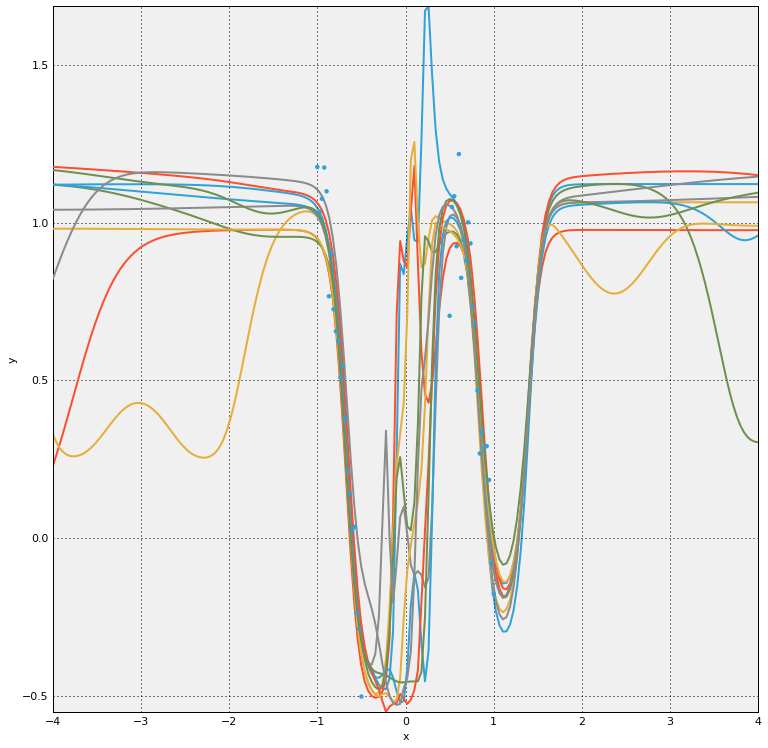

In [32]:
%output size=350
plot_inputs = np.linspace(-4,4,200).reshape(-1,1)
preds = sample_predictions(variational_params, plot_inputs)
hv.Overlay([hv.Curve(zip(plot_inputs.ravel(), p.ravel())) for p in preds])*hv.Points(zip(inputs,targets))

Now that it's trained we can sample weights from our model as if it were the posterior distribution over weights and look at the resulting predictions of our model. We can see that we have captured uncertainty where the model has no data, and fit the data where it is placed.